In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import topography
from skimage.transform import resize

In [2]:
def calc_psi(H_t,h,H_ref):
  """
  Calculate (initial) psi/ surface-to-reference distance.
  """
  return H_t + h - H_ref

def melt_rate(m_p, m_i, h, h_max):
    """
    Calculate total melt rate m based on albedo of melt ponds.
    if h > h_max:
      return 1+ m_p/m_i
    else:
      return 1+ m_p/m_i * h/h_max

    :param m_p: enhancement factor due to the presence of melt ponds
    :param m_i: constant summer melt rate for unponded ice
    :param h: current pond depth
    :param h_max: global pond depth after which the ice-melting process doesn't quickens
    :return: m
    """
    return np.where(h>h_max,1+ m_p/m_i, (1+ m_p/m_i * h/h_max)) * m_i

def melt_rate_neighbors(m_p, m_i, h, h_max):
    """
    Calculate total melt rate m based on albedo of melt ponds.
    if h > h_max:
      return 1+ m_p/m_i
    else:
      return 1+ m_p/m_i * h/h_max

    :param m_p: enhancement factor due to the presence of melt ponds
    :param m_i: constant summer melt rate for unponded ice
    :param h: current pond depth
    :param h_max: global pond depth after which the ice-melting process doesn't quickens
    :return: m
    """
    m = melt_rate(m_p, m_i, h, h_max)

    # define parameters for the neighbors
    axes = [0, 1]
    rolls = [-1, 1]

    # initialize zero array for means of melt rate
    ms = np.zeros(h.shape)

    # add meltrates of neighbors
    for ax in axes:
        for roll in rolls:
            
            ms += np.roll(m, roll, axis=ax)
    
    ms = ms / 4

    m = np.where(ms>m, ms, m)
    return m


In [3]:
def melt_drain(h, delta_t, m, rho_ice, rho_water, s):
    """
    Discretisation of dhdt. Calculates next value for h based on vertical movement only.
    :param h: np.array; current height of water
    :param delta_t: time step
    :param m: melting rate
    :param rho_ice: ice density
    :param rho_water: water density
    :param s: vertical seepage rate
    :return:
    """
    return h + delta_t * (m * (rho_ice / rho_water) - s)

def heaviside(h):
    """
    Prevents the meltwater depth h from becoming negative.
    """
    return np.where(h < 0, 0, 1)

In [4]:
def gradient(x, dx, roll, axis):
    '''
    calculates the gradient between two adjacent cells for an entire 2D array

    Arguments:
        x -- 2D array
        dx -- space interval
        roll -- where to roll (-1, +1)
        axis -- along which axis to roll

    Returns:
        grad -- the gradient between two cells
    '''

    grad = (np.roll(x, roll, axis=axis) - x) /dx

    return grad

def horizontal_flow(psi, h, dt, dx):
    '''
    Calculates the the horizontal flow for all cells based on the ice topography psi
    Note: happens after vertical drainage

    Arguments:
        psi -- 2D array of the ice topography
        dt -- time increment
        dx -- space increment

    Returns:
        dh -- change in water height due to horizontal flow
    '''

    # define constants
    mu = 1.79e-3 # [kg/(m*s)] dynamic viscosity
    pi = 3e-9 # [m^2] horizontal permability
    rho_water = 1000 # [kg/m^3] desity
    g = 9.832 # [m/s^2] gravitational acceleration at the poles

    # calculate all constants togeter
    const = dt * dx * g * rho_water * pi / mu

    # define parameters for the neighbors
    axes = [0, 1]
    rolls = [-1, 1]

    # initialize zero array of water height change
    dh = np.zeros(psi.shape)
    grads = []

    # calculate the in / out flow for each neighbor and sum them up
    for ax in axes:
        for roll in rolls:

            grad = gradient(psi, dx, roll, ax)
            grads.append(grad.mean())

            dh[grad > 0] += const * grad[grad > 0] * np.roll(h, roll, axis=ax)[grad > 0] 
            dh[grad < 0] += const * grad[grad < 0] * h[grad < 0]

    return dh, grads

In [5]:
def calc_H0(psi_0,rho_ice,rho_water):
    """
    Initial ice thickness by assuming hydrostatic equilibrium.
    :param psi_0:
    :param rho_ice:
    :param rho_water:
    :return:
    """
    return psi_0/(1-(rho_ice/rho_water))

def calc_dHtdt(H,m):
  """
  Update of ice-surface height, evolution.
  :param H: Ice height
  :param m: melting rate
  """
  return heaviside(H)*-m

def next_Ht(dHtdt,delta_t,H_t):
  return dHtdt*delta_t + H_t

In [6]:
# Completly fixed constants

# Water and ice densities - fixed values
rho_water = 1000
rho_ice = 900

# Seepage rate
s = 0.008 / (3600 * 24)

pi_h = 3e-9 # horizontal permeability of sea ice
delta_x = 1

m_i = 0.012 / (3600 * 24) # cm/day; unpounded ice melt rate
m_p = 0.02 / (3600 * 24) # cm/day; maximum melt pond enhanced melt rate
h_max = 0.1 # m depth until melting is enhanced

In [7]:
m = m_i # should really follow equation 4

# Size of the array
size = 100

# Timestep
delta_t = 10

psi_0_coarse = np.random.normal(loc = 0.1, scale = 0.1, size = (int(size/5), int(size/5)))
psi_0 = resize(psi_0_coarse, (size, size))

# psi_0 = 0.1 * np.ones((size, size))

#psi_0 = np.random.normal(loc = 0.1, scale = 0.01, size = (size, size))
psi_0 = heaviside(psi_0) * psi_0 + 0.1

# psi_0, X,Y = initial_distributions.valley_distr(size=size)
# psi_0 = heaviside(psi_0) * psi_0

# psi_0, X,Y = initial_distributions.multi_valley(size)
# psi_0 = heaviside(psi_0) * psi_0

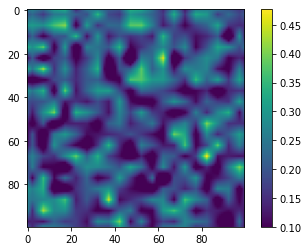

In [8]:
plt.imshow(psi_0)
plt.colorbar()

In [9]:
# Initialise grid water levels - no negative values
h = np.zeros(shape = (size, size))

# F_in = 0.01
# # make random ice water configuration with F_in as fraction of water
# h = np.zeros(size**2)
# h[:int(F_in * size**2)] = 1
# np.random.shuffle(h)

# h = h.reshape((size,size)) * 0.01




# Total ice thickness at initial condition
H0 = calc_H0(psi_0,rho_ice,rho_water)

# Reference point - zero
H_ref = np.zeros(h.shape)

# Set the initial conditions
Ht = psi_0 - h # initially no water, so psi = Ht assuming H_ref = 0
psi= psi_0
H = H0

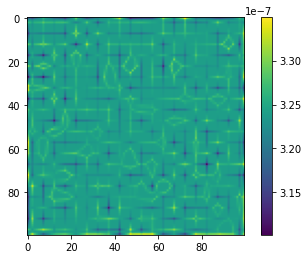

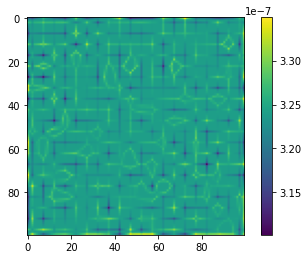

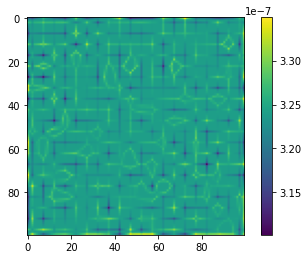

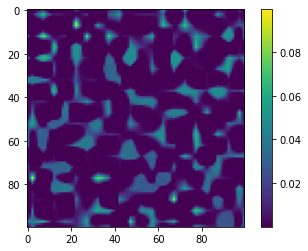

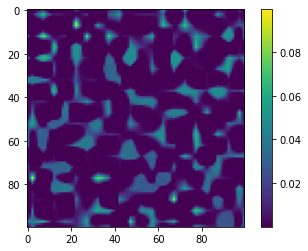

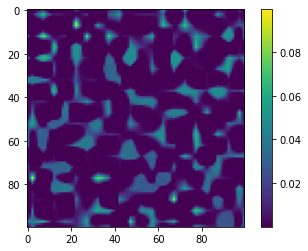

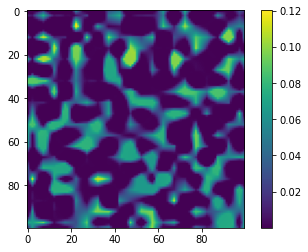

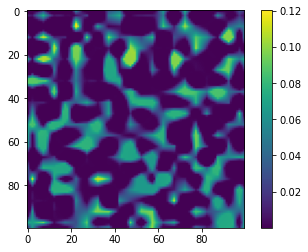

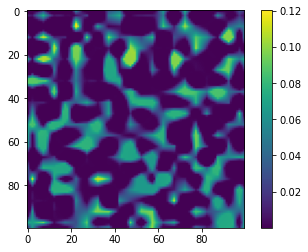

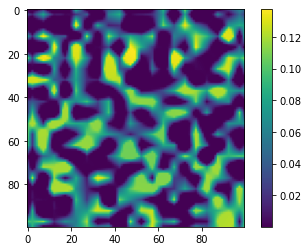

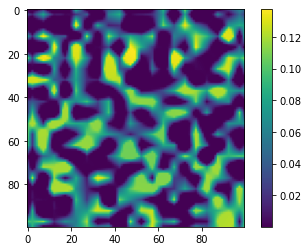

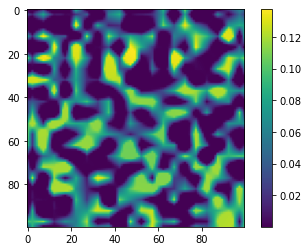

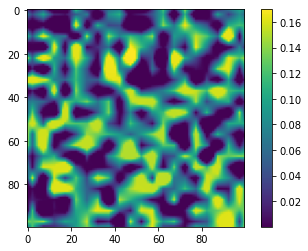

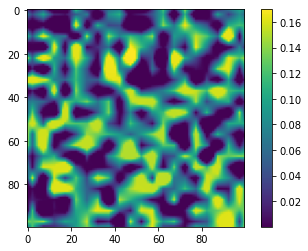

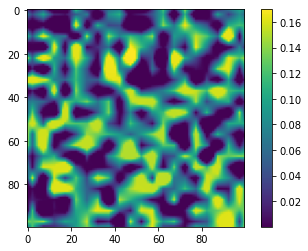

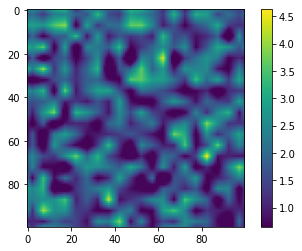

In [10]:
# Hts = []
# grads_list = []
# psis_list = []
# Hs = []
# dHts = []
# hs = []
for i in range(100_000):

    m = melt_rate_neighbors(m_p,m_i,h,h_max)
    h = heaviside(H) * melt_drain(h, delta_t, m, rho_ice, rho_water, s) # h after melt and seepage only
    H = heaviside(H) * (H - delta_t * m) # H after melt
    # Hs.append(H.mean())
    # Ht = heaviside(Ht) * (Ht - m * delta_t) # heaviside(H) * ((-H-h) / (rho_ice / rho_water -1))
    dHt = (((H.mean()-h.mean()) / (rho_ice / rho_water +1)) - Ht.mean()) # change in Ht for the entire floe due to rebalancing
    # dHts.append(dHt)
    Ht = heaviside(H) * (Ht + dHt) #(((H.mean()-h.mean()) / (rho_ice / rho_water +1)) - Ht.mean())) # rebalance Ht after melting and seepage before horizontal flow
    # Hts.append(Ht.mean())
    psi = calc_psi(Ht, h, H_ref) # determine the topography before calculating horizontal flow
    # psis_list.append(psi.mean())
    # hs.append(h.mean())
    dh, grads = horizontal_flow(psi, h, delta_t, delta_x) # determine flow in and out of each cell
    # grads_list.append(grads)
    h = heaviside(H) * (h + dh) # update water depth after horizontal flow

    if not i % 20_000:
        plt.figure()
        plt.imshow(np.ma.masked_where(h<=0, h))
        plt.colorbar()
        plt.show()
        plt.figure()
        plt.imshow(np.ma.masked_where(h[:200, :200]<=0, h[:200, :200]))
        plt.colorbar()
        plt.show()
        plt.imshow(np.ma.masked_where(h[:100, :100]<=0, h[:100, :100]))
        plt.colorbar()
        plt.show()



plt.imshow(H)
plt.colorbar()

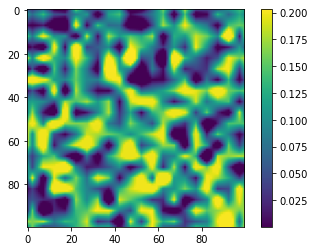

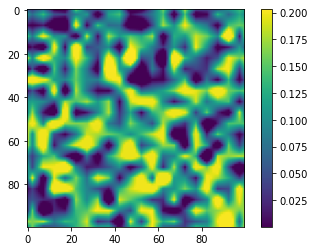

In [11]:
plt.figure()
plt.imshow(np.ma.masked_where(h<=0, h))
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(np.ma.masked_where(h[:200, :200]<=0, h[:200, :200]))
plt.colorbar()
plt.show()

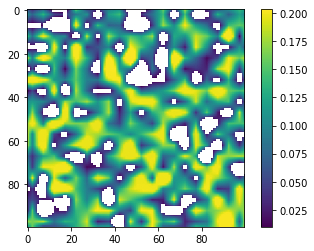

In [12]:
plt.imshow(np.ma.masked_where(h<=0.01, h))
plt.colorbar()

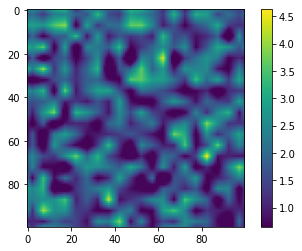

In [13]:
plt.imshow(np.ma.masked_where(H==0, H))
plt.colorbar()